# **Question \#1**

## **Default Setting**

In [ ]:
import tensorflow as tf
print(f"tf.__version__: {tf.__version__}")

tf.__version__: 2.3.0


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!python -V

Python 3.6.9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Dataset**

In [ ]:
!cp "/content/drive/My Drive/인공지능경시대회/train.csv" "./"
!cp "/content/drive/My Drive/인공지능경시대회/test.csv" "./"
!cp "/content/drive/My Drive/인공지능경시대회/sample_submission.csv" "./"

In [ ]:
ls -al

total 91636
drwxr-xr-x 1 root root     4096 Nov  2 09:38 ./
drwxr-xr-x 1 root root     4096 Nov  2 09:32 ../
drwxr-xr-x 1 root root     4096 Oct 28 16:30 .config/
drwx------ 5 root root     4096 Nov  2 09:37 drive/
drwxr-xr-x 1 root root     4096 Oct 28 16:30 sample_data/
-rw------- 1 root root    74526 Nov  2 09:38 sample_submission.csv
-rw------- 1 root root 18745580 Nov  2 09:38 test.csv
-rw------- 1 root root 74988940 Nov  2 09:38 train.csv


In [ ]:
tr_df = pd.read_csv("./train.csv", index_col = 0)
ts_df = pd.read_csv("./test.csv", index_col = 0)

In [ ]:
tr_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,missing
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
2,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,227,...,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0,6
3,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,136,...,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0,NAN
4,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,0,...,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
ts_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,0,0,0,0,0,0,0,0,0,0,0,0,18,143,174,176,150,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94,...,94,91,87,86,85,86,83,75,76,70,32,0,0,0,21,99,125,137,140,153,158,163,170,157,118,2,3,12,11,12,9,10,9,9,8,1,0,0,0,0
15,0,0,0,0,0,0,0,0,16,43,71,55,29,17,18,33,59,88,50,28,0,0,0,0,0,0,0,0,0,0,0,1,0,0,44,90,97,69,61,90,...,73,69,51,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6,23,37,36,23,7,0,0,0,1,1,1,1,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,34,109,9,0,0,80,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,202,239,247,...,255,252,247,255,17,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,96,120,134,155,159,151,126,101,20,0,0,1,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,1,32,88,149,153,89,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,126,177,228,...,139,142,184,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,46,80,110,125,124,121,142,129,103,69,0,0,2,0,0,0,0,0,0


In [ ]:
tr_df["label"]

id
0        missing
1              9
2              6
3            NAN
4              3
          ...   
59990          0
59991          5
59992          5
59993    missing
59999          7
Name: label, Length: 33840, dtype: object

In [ ]:
np.where(tr_df["label"].values == "missing")[0]

4800

In [ ]:
np.where(tr_df["label"].values == "NAN")

(array([  3,  10,  12,  34,  66,  78,  90,  95, 104, 117, 120, 139, 152,
        153, 167, 185, 186, 198, 215, 232, 253, 261, 269, 282, 289, 311,
        321, 323, 327, 334, 343, 348, 350, 358, 370, 371, 372, 379, 381,
        383, 389, 392, 400, 408, 410, 412, 430, 449, 496, 504, 512, 513,
        517, 523, 524, 527, 544, 552, 553, 564, 571, 574, 575, 592, 608,
        609, 617, 644, 652, 660, 664, 668, 675, 680, 690, 691, 692, 697,
        703, 704, 705, 715, 724, 730, 737, 743, 749]),)

In [ ]:
tr_df["label"].unique()

array(['missing', '9', '6', 'NAN', '3', '4', '5', '8', '7', '1', '0'],
      dtype=object)

In [ ]:
tr_df["label"].value_counts()

1          4800
7          4800
missing    4800
5          4800
6          4800
4          4800
0          4713
NAN          87
3            80
8            80
9            80
Name: label, dtype: int64

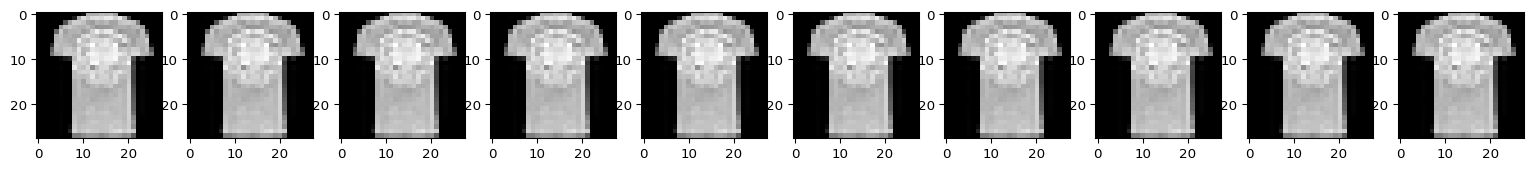

In [ ]:
aa = tr_df[tr_df["label"] == "0"].values

plt.figure(figsize = (20, 5), facecolor = "white", dpi = 96)

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(np.reshape(aa[0][:-1], (28, 28)).astype(np.int64), cmap = "gray")

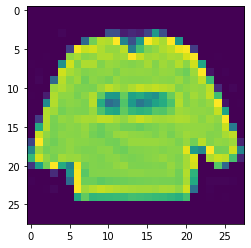

In [ ]:
plt.imshow(np.reshape(tr_df.iloc[0].values[:-1].astype(np.int64), (28, 28)))

In [ ]:
tr_df.iloc[0][:-1]

pixel1            0
pixel2            0
pixel3            0
pixel4            0
pixel5            0
             ...   
pixel781          0
pixel782          0
pixel783          0
pixel784          0
label       missing
Name: 0, Length: 785, dtype: object

## **Make Dataset Pipeline**

In [ ]:
tr_X = tr_df.values
ts_X = ts_df.values

tr_X.shape, ts_X.shape

((33840, 785), (8460, 784))

In [ ]:
tr_Y = tr_X[:, -1]
tr_X = tr_X[:, :-1]

tr_X.shape, tr_Y.shape

((33840, 784), (33840,))

In [ ]:
np.unique(tr_Y) 

array(['0', '1', '3', '4', '5', '6', '7', '8', '9', 'NAN', 'missing'],
      dtype=object)

In [ ]:
# NAN -> "0" / Missing -> "2"
tr_Y = np.where(tr_Y == "NAN", "0", tr_Y)
tr_Y = np.where(tr_Y == "missing", "2", tr_Y)

np.unique(tr_Y)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
tr_Y = tf.keras.utils.to_categorical(tr_Y)
tr_Y.shape

(33840, 10)

In [ ]:
@tf.function
def reshape_fn_tr(flatten_image, label):
    return tf.reshape(flatten_image, (28, 28, 1)), label


@tf.function
def resize_and_rescale_fn_tr(image, label):
    image = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(image)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    return image, label


@tf.function
def reshape_fn_ts(flatten_image):
    return tf.reshape(flatten_image, (28, 28, 1))


@tf.function
def resize_and_rescale_fn_ts(image):
    image = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(image)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    return image

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
tr_X_tensor = tf.convert_to_tensor(tr_X, dtype = tf.int64)
tr_Y_tensor = tf.convert_to_tensor(tr_Y, dtype = tf.int64)

tr_dataset = tf.data.Dataset.from_tensor_slices((tr_X_tensor, tr_Y_tensor)).shuffle(100_000)

vl_dataset = tr_dataset.take(5000)
tr_dataset = tr_dataset.skip(5000)

In [ ]:
tr_dataset.element_spec

(TensorSpec(shape=(784,), dtype=tf.int64, name=None),
 TensorSpec(shape=(10,), dtype=tf.int64, name=None))

In [ ]:
vl_dataset.element_spec

(TensorSpec(shape=(784,), dtype=tf.int64, name=None),
 TensorSpec(shape=(10,), dtype=tf.int64, name=None))

In [ ]:
BATCH_SIZE = 128

tr_dataset = tr_dataset.map(reshape_fn_tr, num_parallel_calls = AUTO
                            ).batch(BATCH_SIZE
                            ).map(resize_and_rescale_fn_tr, num_parallel_calls = AUTO
                            ).cache(
                            ).prefetch(AUTO)

vl_dataset = vl_dataset.map(reshape_fn_tr, num_parallel_calls = AUTO
                            ).batch(BATCH_SIZE
                            ).map(resize_and_rescale_fn_tr, num_parallel_calls = AUTO
                            ).cache(
                            ).prefetch(AUTO)

In [ ]:
tr_dataset.element_spec

(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.int64, name=None))

In [ ]:
vl_dataset.element_spec

(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.int64, name=None))

In [ ]:
ts_dataset = tf.data.Dataset.from_tensor_slices((ts_X)
                            ).map(reshape_fn_ts, num_parallel_calls = AUTO
                            ).batch(BATCH_SIZE
                            ).map(resize_and_rescale_fn_ts, num_parallel_calls = AUTO
                            ).cache(
                            ).prefetch(AUTO)

In [ ]:
ts_dataset.element_spec

TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)

## **Create Network**

In [ ]:
def bn_relu_conv(x, filters,  kernel_size):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides = 1, padding = "valid")(x)
    return x


def create_NN(model_name):
    model_input = tf.keras.layers.Input((128, 128, 1))
    
    # Augmentation
    x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1, fill_mode = "constant")(model_input)
    x = tf.keras.layers.experimental.preprocessing.RandomFlip()(x)

    # Stem
    x = tf.keras.layers.Conv2D(64, 7, strides = 2, padding = "same", activation = "relu")(model_input)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides = 2, padding = "same")(x)

    # Body
    x = bn_relu_conv(x, 128, 3)
    x = tf.keras.layers.MaxPooling2D((3, 3), padding = "same")(x)
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)

    x = bn_relu_conv(x, 192, 3)
    x = tf.keras.layers.MaxPooling2D((3, 3), padding = "same")(x)
    x = tf.keras.layers.SpatialDropout2D(0.3)(x)

    x = bn_relu_conv(x, 256, 3)
    x = tf.keras.layers.MaxPooling2D((3, 3), padding = "same")(x)
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(x.shape[-1], activation = "relu")(x)
    
    x = tf.keras.layers.Dense(10)(x)
    model_output = tf.keras.layers.Softmax()(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name
    )

In [ ]:
tmp = create_NN("tmp")
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 64, 64, 64)        3200      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu_79 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 30, 30, 128)       73856     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 10, 10, 128)       0       

In [ ]:
del tmp

## **Fit the Network**

In [ ]:
model = create_NN("model")
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(3e-3),
    metrics = ["accuracy"]
)

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: 0.96 * lr)
es_callback = tf.keras.callbacks.EarlyStopping(verbose = 2, restore_best_weights = True, patience = 10)

_ = model.fit(
    tr_dataset, 
    validation_data = vl_dataset, 
    epochs = 30,
    verbose = 1,
    callbacks = [lr_callback, es_callback])

Epoch 1/30
226/226 [==============================] - 3s 15ms/step - loss: 0.6138 - accuracy: 0.7793 - val_loss: 1.4202 - val_accuracy: 0.5426
Epoch 2/30
226/226 [==============================] - 3s 15ms/step - loss: 0.3591 - accuracy: 0.8600 - val_loss: 0.4543 - val_accuracy: 0.8172
Epoch 3/30
226/226 [==============================] - 3s 14ms/step - loss: 0.3154 - accuracy: 0.8783 - val_loss: 0.3424 - val_accuracy: 0.8744
Epoch 4/30
226/226 [==============================] - 3s 15ms/step - loss: 0.2817 - accuracy: 0.8917 - val_loss: 0.2685 - val_accuracy: 0.9028
Epoch 5/30
226/226 [==============================] - 3s 15ms/step - loss: 0.2611 - accuracy: 0.8983 - val_loss: 0.2406 - val_accuracy: 0.9112
Epoch 6/30
226/226 [==============================] - 3s 15ms/step - loss: 0.2453 - accuracy: 0.9064 - val_loss: 0.2220 - val_accuracy: 0.9162
Epoch 7/30
226/226 [==============================] - 3s 14ms/step - loss: 0.2254 - accuracy: 0.9121 - val_loss: 0.3087 - val_accuracy: 0.8870

## **Make Submission**

In [ ]:
y_pred = model.predict(ts_dataset, verbose = 1)
y_pred.shape

67/67 [==============================] - 0s 6ms/step


(8460, 10)

In [ ]:
submission = pd.read_csv("sample_submission.csv", index_col = 0)
submission.head()

,label
id,
11,1
15,1
17,1
21,1
22,1


In [ ]:
submission["label"] = np.argmax(y_pred, axis = 1)
submission.head()

,label
id,
11,8
15,2
17,4
21,7
22,4


In [ ]:
submission.tail()

,label
id,
59970,7
59971,5
59982,5
59986,6
59996,1


In [ ]:
submission.to_csv("./submission_5.csv")

try:
    from google.colab import files
    files.download("submission_5.csv")
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>